In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from six.moves import urllib
import seaborn as sns
import time

from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nltk.tokenize import RegexpTokenizer  
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.pipeline import make_pipeline

import pickle# use to dump model 

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
csv0 = pd.read_csv('E:/Codes/Python/ML Phising Detector/Datasets/phishing_site_urls.csv')
csv0.columns = ['URL','Label']
csv1 = pd.read_csv('E:/Codes/Python/ML Phising Detector/Datasets/urldata.csv')
csv1.columns = ['URL','Label']
csv2 = pd.read_csv('E:/Codes/Python/ML Phising Detector/Datasets/urls.csv')
csv2.columns = ['URL','Label']
dfeval = pd.read_csv('E:/Codes/Python/ML Phising Detector/Datasets/test.csv')

In [3]:
frames = [csv0, csv1, csv2]
cFrames = pd.concat(frames)
cFrames.to_csv('E:/Codes/Python/ML Phising Detector/Datasets/final_urls.csv', index = False)
dftrain = pd.read_csv('E:/Codes/Python/ML Phising Detector/Datasets/final_urls.csv')

In [4]:
print(dftrain.head(10))
print(dftrain.index)

                                                 URL  Label
0                           wibcjkwrk.ru/checkupdate      1
1                 en.wikipedia.org/wiki/Maiko_Watson      0
2  tvosxdfmkciqxvpwvbbnnrjifawkhznzifyx.offgl8876...      1
3                                  lloydsalert.co.uk      1
4                  onlinehuntintonbank.accesscam.org      1
5                              rbbn-cz-secure.online      1
6  heilpraktikerin-edhofer.de/wp-includes/pomo/ne...      1
7  attloginnewupdatingservicemailcommunication.we...      1
8                                     incomeways.icu      1
9  gallery.skcentral.com/displayimage.php?album=3...      0
RangeIndex(start=0, stop=1300448, step=1)


In [5]:
label_counts = pd.DataFrame(dftrain.Label.value_counts())
print(label_counts)

    Label
0  738213
1  562235


c:\users\steven\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='Label'>

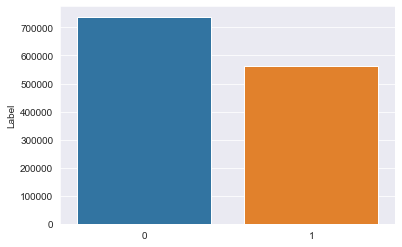

In [6]:
sns.set_style('darkgrid')
sns.barplot(label_counts.index,label_counts.Label)

In [7]:
def treat_data(datain):
    tokenizer = RegexpTokenizer(r'[A-Za-z]+')
    tokenizer.tokenize(datain.URL[0])
    print('Getting words tokenized ...')
    t0= time.perf_counter()
    datain['text_tokenized'] = datain.URL.map(lambda t: tokenizer.tokenize(t))
    t1 = time.perf_counter() - t0
    print('Time taken',t1 ,'sec')

    stemmer = SnowballStemmer("english")
    print('Getting words stemmed ...')
    t0= time.perf_counter()
    datain['text_stemmed'] = datain['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])
    t1= time.perf_counter() - t0
    print('Time taken',t1 ,'sec')

    print('Getting joiningwords ...')
    t0= time.perf_counter()
    datain['text_sent'] = datain['text_stemmed'].map(lambda l: ' '.join(l))
    t1= time.perf_counter() - t0
    print('Time taken',t1 ,'sec')

    dataout = datain
    return dataout

In [8]:
dftrain = treat_data(dftrain)
dftrain.shape

Getting words tokenized ...
Time taken 3.7509879999999995 sec
Getting words stemmed ...
Time taken 58.4706655 sec
Getting joiningwords ...
Time taken 0.3425393999999926 sec


(1300448, 5)

In [9]:
dftrain.sample(10)

,URL,Label,text_tokenized,text_stemmed,text_sent
894928,awesometime4you.com/wp-admin/js/cmfr/224d1e468...,1,"[awesometime, you, com, wp, admin, js, cmfr, d...","[awesometim, you, com, wp, admin, js, cmfr, d,...",awesometim you com wp admin js cmfr d e b c d ...
437488,bayshore-technologies.com,1,"[bayshore, technologies, com]","[bayshor, technolog, com]",bayshor technolog com
669398,youtube.com/watch?v=od04lZ-aVAc,0,"[youtube, com, watch, v, od, lZ, aVAc]","[youtub, com, watch, v, od, lz, avac]",youtub com watch v od lz avac
598743,looginlivemicrftline.com,1,"[looginlivemicrftline, com]","[looginlivemicrftlin, com]",looginlivemicrftlin com
678986,dcvsmbuayb.hohyzuxpp.net/bfc6xnctj3\n2pvi59m4u...,1,"[dcvsmbuayb, hohyzuxpp, net, bfc, xnctj, n, pv...","[dcvsmbuayb, hohyzuxpp, net, bfc, xnctj, n, pv...",dcvsmbuayb hohyzuxpp net bfc xnctj n pvi m u l...
607114,saequity.com/wp-includes/SimplePie/Parse/~/Mai...,1,"[saequity, com, wp, includes, SimplePie, Parse...","[saequiti, com, wp, includ, simplepi, pars, ma...",saequiti com wp includ simplepi pars maikudire...
983620,inside.anime-expo.org/ax-scoop/2011-05/chart-t...,0,"[inside, anime, expo, org, ax, scoop, chart, t...","[insid, anim, expo, org, ax, scoop, chart, top...",insid anim expo org ax scoop chart top japanes...
766964,asloid.com,1,"[asloid, com]","[asloid, com]",asloid com
547923,a70892jf.beget.tech,1,"[a, jf, beget, tech]","[a, jf, beget, tech]",a jf beget tech
168086,divsteel.com,1,"[divsteel, com]","[divsteel, com]",divsteel com


In [10]:
dfeval = treat_data(dfeval)
dfeval.shape

Getting words tokenized ...
Time taken 0.00069360000000529 sec
Getting words stemmed ...
Time taken 0.00684540000000311 sec
Getting joiningwords ...
Time taken 0.00046489999999721476 sec


(133, 5)

In [11]:
dfeval.sample(10)

,URL,Label,text_tokenized,text_stemmed,text_sent
32,paxful-maintenances.com,1,"[paxful, maintenances, com]","[pax, mainten, com]",pax mainten com
50,ruleschange-xy0a0chmh6.theprivategarden.ae,1,"[ruleschange, xy, a, chmh, theprivategarden, ae]","[ruleschang, xy, a, chmh, theprivategarden, ae]",ruleschang xy a chmh theprivategarden ae
103,city-data.com/city/Waverly-Missouri.html,0,"[city, data, com, city, Waverly, Missouri, html]","[citi, data, com, citi, waver, missouri, html]",citi data com citi waver missouri html
110,songlyrics.com/the-luyas/too-beautiful-to-work...,0,"[songlyrics, com, the, luyas, too, beautiful, ...","[songlyr, com, the, luya, too, beauti, to, wor...",songlyr com the luya too beauti to work lyric
123,shropshirestar.com/sport/wolverhampton-wandere...,0,"[shropshirestar, com, sport, wolverhampton, wa...","[shropshirestar, com, sport, wolverhampton, wa...",shropshirestar com sport wolverhampton wander ...
122,elxosnfere.web.app,1,"[elxosnfere, web, app]","[elxosnfer, web, app]",elxosnfer web app
49,amt.netingel.com,1,"[amt, netingel, com]","[amt, netingel, com]",amt netingel com
38,hoosierhillshoops.com/2011/08/05/new-albanys-w...,0,"[hoosierhillshoops, com, new, albanys, whitehe...","[hoosierhillshoop, com, new, albani, whitehead...",hoosierhillshoop com new albani whitehead head...
2,hampshirepolicechoir.org.uk/,0,"[hampshirepolicechoir, org, uk]","[hampshirepolicechoir, org, uk]",hampshirepolicechoir org uk
24,182.92.184.208:8806/hao123.bat,1,"[hao, bat]","[hao, bat]",hao bat


In [12]:
cv = CountVectorizer()
feature = cv.fit_transform(dftrain.text_sent)
feature[:5].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [13]:
trainX, testX, trainY, testY = train_test_split(feature, dftrain.Label)

In [14]:
lr = LogisticRegression(max_iter=5000)
lr.fit(trainX,trainY)

LogisticRegression(max_iter=5000)

In [15]:
lr.score(testX,testY)

0.9441669332414676

In [16]:
Scores_ml = {}
Scores_ml['Logistic Regression'] = np.round(lr.score(testX,testY),2)

Training Accuracy : 0.9782680020013615
Testing Accuracy : 0.9441669332414676

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.93      0.97      0.95    175586
        Good       0.97      0.91      0.94    149526

    accuracy                           0.94    325112
   macro avg       0.95      0.94      0.94    325112
weighted avg       0.95      0.94      0.94    325112


CONFUSION MATRIX


<AxesSubplot:>

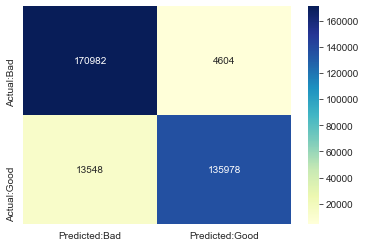

In [17]:
print('Training Accuracy :',lr.score(trainX,trainY))
print('Testing Accuracy :',lr.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(lr.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(lr.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [18]:
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression(max_iter=5000))

In [19]:
trainX, testX, trainY, testY = train_test_split(dftrain.URL, dftrain.Label)

In [20]:
pipeline_ls.fit(trainX,trainY)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)),
                ('logisticregression', LogisticRegression(max_iter=5000))])

In [21]:
pipeline_ls.score(testX,testY)

0.9452926991313763

In [22]:
pickle.dump(pipeline_ls,open('E:/Codes/Python/ML Phising Detector/phishing_detector.pkl','wb'))

In [23]:
loaded_model = pickle.load(open('E:/Codes/Python/ML Phising Detector/phishing_detector.pkl', 'rb'))

In [24]:
test = ['https://github.com/taruntiwarihp/Projects_DS/blob/master/Phishing Site URLs Prediction/prediction_app.py']
probability = loaded_model.predict_proba(test)
result = loaded_model.predict(test)
print(probability, result)

[[2.41598759e-04 9.99758401e-01]] [1]


In [25]:
print(probability[0,1])

0.9997584012407281
